Importing plotly failed. Interactive plots will not work.


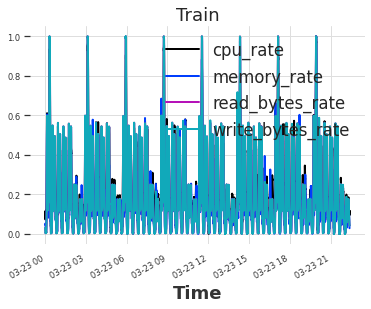

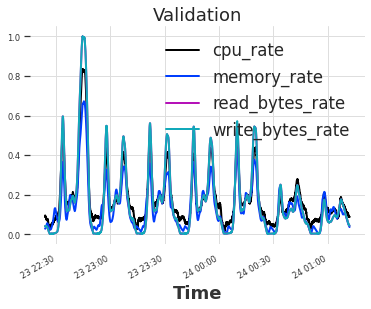

In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["LD_LIBRARY_PATH"] = "/home/jupyter-babakesistani/.conda/envs/thesis/lib/"

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import numpy as np
import random
from sklearn.model_selection import KFold

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.use_deterministic_algorithms(True)
np.random.seed(seed)

import seaborn as sns

# Prettier plotting with seaborn
sns.set(font_scale=1.5)
# Ticks instead of whitegrid in order to demonstrate changes to plot ticks better
sns.set_style("ticks")

import pandas as pd
from darts.models import (
    BlockRNNModel,
)
from darts import TimeSeries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt
from darts.metrics import rho_risk
import matplotlib.pyplot as plt

import sys
sys.path.append("/home/jupyter-babakesistani/adaptive-monitoring-nn/")
from pipeline.dataset.dataset_loader import DatasetLoader



dl =  DatasetLoader( '/home/jupyter-babakesistani/adaptive-monitoring-nn/pipeline/data/cpu_memory_disk_23_march.csv', "Time",
                                                                    [
                                                                      "cpu_rate",
                                                                      "memory_rate",
                                                                      "read_bytes_rate",
                                                                      "write_bytes_rate"
                                                                     ],
                    augment=False, resample_freq="1s", shift_df_datetime="2022-03-23 00:00:00")
scaled_one_day = 24*60
scaled_one_week = 7*24*60
idx_train = 8*scaled_one_week
idx_val = 9*scaled_one_week
train = dl.series_scaled[:idx_train]
val = dl.series_scaled[idx_train:idx_val]
    
train.plot()
plt.title("Train")

val.plot(new_plot=True)
plt.title("Validation")


def day_of_week(idxs):
    days = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) // (24*60)) % 7
    encoders = []
    for day in days:
        if day == 0:
            encoders.append(1)
        elif day == 1 or day == 2 or day == 3 or day == 4: 
            encoders.append(2)
        elif day == 5 or day == 6:
            encoders.append(3)
    return encoders

def minute_of_day(idxs):    
    minute_of_day = ((idxs.second + idxs.minute*60 + idxs.hour*60*60 + idxs.dayofweek*24*60*60) % (24*60))
    return minute_of_day



KFold(n_splits=9, random_state=None, shuffle=False)
TRAIN: [1 2 3 4 5 6 7 8] TEST: [0]
TRAIN: [0 2 3 4 5 6 7 8] TEST: [1]
TRAIN: [0 1 3 4 5 6 7 8] TEST: [2]
TRAIN: [0 1 2 4 5 6 7 8] TEST: [3]
TRAIN: [0 1 2 3 5 6 7 8] TEST: [4]
TRAIN: [0 1 2 3 4 6 7 8] TEST: [5]
TRAIN: [0 1 2 3 4 5 7 8] TEST: [6]
TRAIN: [0 1 2 3 4 5 6 8] TEST: [7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [8]


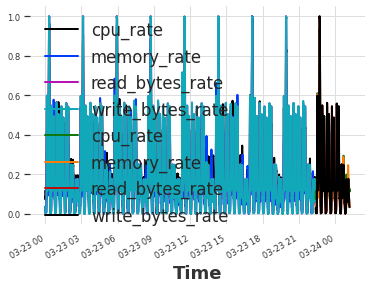

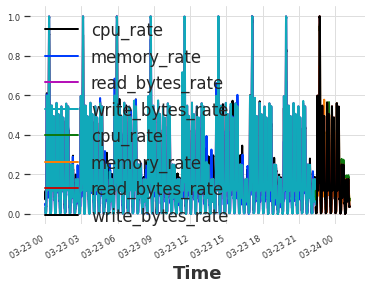

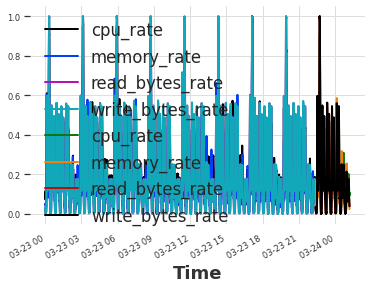

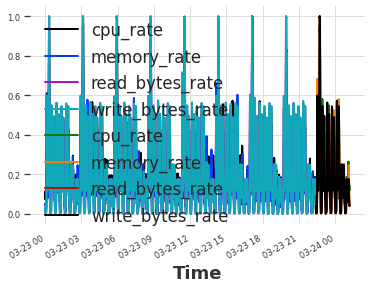

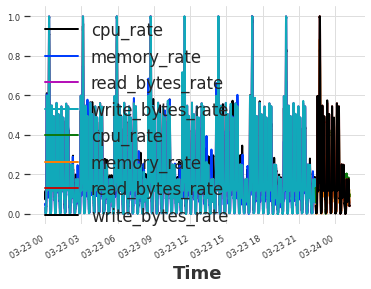

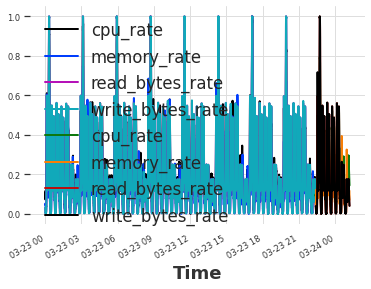

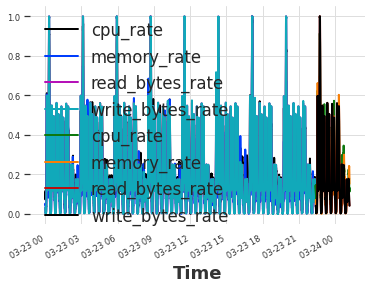

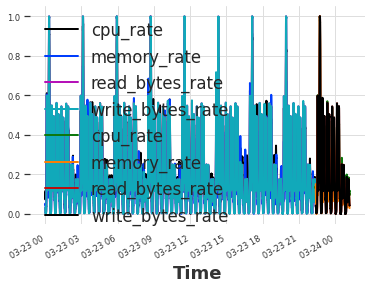

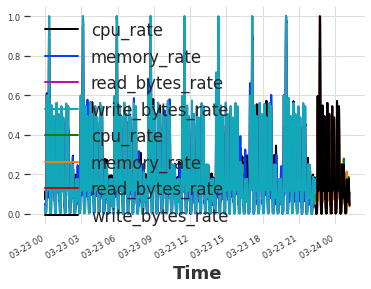

In [2]:
train_time_index = train.time_index.copy()
val_time_index = val.time_index.copy()
cross_series = dl.series_scaled[:-1]

X = list(range(0,9))
kf = KFold(n_splits=9)
kf.get_n_splits(X)

print(kf)
train_cross_list = []
val_cross_list = []
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    train_concat = None
    for i, tidx in enumerate(train_index):
        if i == 0:
            train_concat = cross_series[tidx*scaled_one_week:(tidx+1)*scaled_one_week].values()
            continue
        train_concat = np.concatenate((train_concat,cross_series[tidx*scaled_one_week:(tidx+1)*scaled_one_week].values()))
    train_cross = TimeSeries.from_times_and_values(times=train_time_index,values=train_concat, columns=train.columns)
    train_cross_list.append(train_cross)
    val_concat = cross_series[test_index[0]*scaled_one_week:(test_index[0]+1)*scaled_one_week]
    val_cross = TimeSeries.from_times_and_values(times=val_time_index, values=val_concat.values(), columns=train.columns)
    val_cross_list.append(val_cross)
    train_cross.plot(new_plot=True)
    val_cross.plot()
    

In [ ]:
quantiles = [0.1, 0.5, 0.9]
for i in range(9):
    model = BlockRNNModel(
        model="LSTM",
        model_name="cross_validation_"+str(i),
        input_chunk_length=300,
        output_chunk_length=300,
        hidden_size=75,
        n_rnn_layers=2,
        batch_size=256,
        n_epochs=20,
        dropout=0.2,
        add_encoders={
        'cyclic': {'past': ['second','month']},
        'custom': {'past': [day_of_week, minute_of_day]},
        'transformer': Scaler()
        },
        likelihood=QuantileRegression(
            quantiles=quantiles
        ), 
        save_checkpoints=True,
        work_dir="logs/cross_validation/",
        nr_epochs_val_period=1,
        optimizer_kwargs={"lr": 1e-3},
        log_tensorboard=True,
        random_state=seed,
        force_reset=True,
        torch_device_str='cuda:0'
    )
    model.fit(train_cross_list[i], val_series=val_cross_list[i], verbose=True)

[2022-06-19 14:53:04,337] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 14:53:04,337] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 14:53:04,344] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-19 14:53:04,344] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-19 14:53:06.845187: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-06-19 15:16:25,713] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 15:16:25,713] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 15:16:25,720] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-19 15:16:25,720] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-06-19 15:39:38,396] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 15:39:38,396] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 15:39:38,403] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-19 15:39:38,403] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/20 [00:00<?, ?it/s]

[2022-06-19 16:03:01,210] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 16:03:01,210] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 80041 samples.
[2022-06-19 16:03:01,217] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-19 16:03:01,217] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/20 [00:00<?, ?it/s]